# Prerequisite Libraries

In [1]:
# Must-have modules
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
# Pytorch modules
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

# Data Transform and Dataloaders

In [3]:
""" Initiate input image transformation for data augmentation """
from torchvision import transforms

transforms_noise = transforms.Compose([transforms.RandomAffine(5, translate=(0.04, 0.04), scale=(0.96, 1.04)),
                                       transforms.ToTensor()])

transforms_ref = transforms.Compose([transforms.ToTensor(),])

In [4]:
""" Initiate dataloaders """
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
               torchvision.datasets.MNIST('./ML_data', train=True, download=True, transform=transforms_noise), 
               batch_size=batch_size_train, shuffle=True, num_workers=4, pin_memory=True)

train_loader_ref = torch.utils.data.DataLoader(
               torchvision.datasets.MNIST('./ML_data', train=True, download=True, transform=transforms_ref), 
               batch_size=batch_size_train, shuffle=True, num_workers=4, pin_memory=True)

test_loader_ref = torch.utils.data.DataLoader(
              torchvision.datasets.MNIST('./ML_data', train=False, download=True, transform=transforms_ref),
              batch_size=batch_size_test, shuffle=False,  num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
              torchvision.datasets.MNIST('./ML_data', train=False, download=True, transform=transforms_noise),
              batch_size=batch_size_test, shuffle=False,  num_workers=4, pin_memory=True)

# Model Definitions

The same as the definition code blocks in the training scripts, plus the helper functions to model shot noise.

In [5]:
""" Helper classes and functions for modeling photon noise """

def shot_noise(W, X, n_photons_target):
    # W_til is obtained through normalizing W with its max and min (all entries of W_til are non-negative)
    W_til = W - torch.min(W)
    K_W = torch.max(W_til)
    W_til = W_til / K_W
    
    # X_til is obtained through normalizing X with each sample max
    K_X = torch.max(X, dim=1, keepdim=True)[0]
    X_til = X / K_X

    # The product of the normalized W and X is proportional to the intensity of each pixel on the camera
    W_til_X_til = torch.mm(X_til, W_til)
    
    # Calculate the photon budget for each multiplication at the input
   # avg_photons_per_MAC = X_til.sum(dim=1) * n_photons_max / X_til.size(1)
    n_photons_maxs = torch.div(n_photons_target * X_til.size(1), X_til.sum(dim=1)) 
    
    #set_trace()
    # Calculate the photon shot noise based on each pixel intensity.
    if n_photons_target != 0:
        with torch.no_grad():
            fluence_Wx = W_til_X_til * n_photons_maxs.view(-1,1)
            fluence_Wx[torch.isnan(fluence_Wx)] = 0.0
            noise_Wx = torch.poisson(fluence_Wx) - fluence_Wx
            noise = torch.div(K_X * noise_Wx * K_W, n_photons_maxs.view(-1,1))
    else:
        noise = torch.zeros_like(W_til_X_til)
    return noise, W_til, X_til, n_photons_maxs


class noise_scheduler(object):
    def __init__(self, pCounts=[0,], times=[0,]):
        self.max_photon_counts = pCounts
        self.switching_times = times # switching_times[i] is the epoch index before within multiplicative_coeffs[i] is armed
        self.current_photon_counts = 0.0
        
    def update_current_photon_counts(self, epoch):
        earlier_times = (self.switching_times <= epoch)
        if earlier_times.nonzero().numel() != 0: 
            self.current_photon_counts = self.max_photon_counts[earlier_times][-1]

In [6]:
""" Definition of digitized fully connected layers """

def Digitize(tensor, quant_mode='det', levels=16, min_val=None, max_val=None):
    if not min_val and not max_val:
        min_val, max_val = tensor.min(), tensor.max()
    tensor.clamp_(min_val, max_val).add_(-1*min_val).mul_(levels-1).div_(max_val-min_val)
    if quant_mode == "det": 
        tensor.round_()
    elif quant_mode == "rand":
        tensor.add_(torch.rand(tensor.size(), device=tensor.device).add_(-0.5)).round_()
    tensor.mul_(max_val-min_val).div_(levels-1).add_(min_val)
    return tensor

class DigitizeLinear(nn.Linear):

    def __init__(self,  *kargs, a_quant_mode="det", w_quant_mode="det", a_quant_levels=16, w_quant_levels=32, running_weight=0.001, **kwargs):
        super(DigitizeLinear, self).__init__(*kargs, **kwargs)
        self.act_quant_mode = a_quant_mode
        self.weight_quant_mode = w_quant_mode
        self.register_buffer("act_quant_levels", torch.tensor(a_quant_levels))
        self.register_buffer("weight_quant_levels", torch.tensor(w_quant_levels))
        self.register_buffer("running_weight", torch.tensor(running_weight)) 
        self.register_buffer("running_min", None)
        self.register_buffer("running_max", None)

    def forward(self, input):

        if not self.weight_quant_mode is None: # Set a flag to control weight digitization.
            if not hasattr(self.weight,'org'):
                self.weight.org=self.weight.data.clone()
            self.weight.data=Digitize(self.weight.data, quant_mode=self.weight_quant_mode, levels=self.weight_quant_levels)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()    
        out = nn.functional.linear(input, self.weight, bias=self.bias)

        if not self.act_quant_mode is None: # A flag to control output digitization. 
            if self.training: # Update the running average of min and max only during training
                with torch.no_grad():
                    if not self.running_min and not self.running_max:
                        self.running_min, self.running_max = out.min(), out.max()
                    self.running_min = (1-self.running_weight) * self.running_min + self.running_weight * out.min()
                    self.running_max = (1-self.running_weight) * self.running_max + self.running_weight * out.max()
            out.data=Digitize(out.data, quant_mode=self.act_quant_mode, levels=self.act_quant_levels, min_val=self.running_min, max_val=self.running_max)
    
        return out

In [7]:
""" Definition of QAT NN structure """

class QNN(nn.Module):
    def __init__(self, Nunits, ns, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([DigitizeLinear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])
        self.noise_scheduler = ns
        self.photons_per_multiplication = torch.zeros(len(Nunits)-1)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            noise, W_til, X_til, avg_ppm = shot_noise(fc.weight.t(), X, self.noise_scheduler.current_photon_counts) 
            self.photons_per_multiplication[i] = avg_ppm.mean().detach()
            X = fc(X) + noise
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X
    
    def set_digitize_config(self, a_quant_mode, w_quant_mode, a_quant_levels, w_quant_levels):
        for fc in self.fcs:
            fc.act_quant_mode = a_quant_mode
            fc.weight_quant_mode = w_quant_mode
            fc.act_quant_levels = torch.tensor(a_quant_levels)
            fc.weight_quant_levels = torch.tensor(w_quant_levels)
        

# Scan Accuracy for Noise Levels and Models

In [8]:
# Path management for MacOS and Windows
from pathlib import Path
import os, sys

scriptPath = Path(sys.path[0])
parentPath = Path(sys.path[0]).parent
accuracy_ref = {}
accuracy_aug = {}
photon_budgets = {}
models = {}

class args():
    pass
args.cuda = False

In [9]:
def model_validation(model, device, data_loader):
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    for data, target in data_loader:
        if args.cuda:
            data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    return {"accuracy": accuracy, "test_loss": test_loss}

In [10]:
import pandas

# Specify photon budget levels (photons per multiplication)
max_photon_mac = torch.cat((10**torch.arange(-2, 4.2, 0.2), torch.tensor([1.8, 2.0, 2.3])), 0).sort()[0]

# Construct MLP model
device=torch.device("cpu")
Nunits = [784, 100, 100, 10]
ns1 = noise_scheduler(torch.tensor([0.0,]), torch.tensor([0.0,]))
model = QNN(Nunits, ns1).to(device)

# Load the trained parameters
model_ckpt = torch.load("./RA_4bit_H2_100_100_lr_0.043_0.50_m_0.87_wep_6_randActDigi_v80_ep97.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
for l in model.fcs:
    l.running_min = torch.tensor(0.0) #running_min is not initiated in model as registered_buffer
    l.running_max = torch.tensor(0.0)
    l.training = False
model.load_state_dict(model_state_dict)

# Construct dataframe to save the results
df_state = pandas.DataFrame(index=range(len(max_photon_mac)), \
                           columns=["max p/mul", "fc0 p/mul", "fc1 p/mul", "fc2 p/mul", "accu_ref", "accu_aug", "fc0 fullres", "fc1 fullres", "fc2 fullres", "accu_ref_fullres", "accu_aug_fullres"])

# Test MLP model under photon shot noise
model.eval()
for i, pc in enumerate(max_photon_mac):
    model.noise_scheduler.current_photon_counts = pc
    results_ref = model_validation(model, device, test_loader_ref)    
    results_aug = model_validation(model, device, test_loader)
    df_state.loc[i, "max p/mul"] = pc.item()
    for l in range(len(model.fcs)):
        df_state.loc[i, f"fc{l} p/mul"] = model.photons_per_multiplication[l].item()
    df_state.loc[i, "accu_ref"] = results_ref["accuracy"].numpy()
    df_state.loc[i, "accu_aug"] = results_aug["accuracy"].numpy()

    # evaluate for (almost) full float resolution models
    model.set_digitize_config(None, None, 2048, 2048)
    for i, pc in enumerate(max_photon_mac):  
        model.noise_scheduler.current_photon_counts = pc
        results_ref = model_validation(model, device, test_loader_ref)    
        results_aug = model_validation(model, device, test_loader)
        for l in range(len(model.fcs)):
            df_state.loc[i, f"fc{l} fullres"] = model.photons_per_multiplication[l].item()
        df_state.loc[i, "accu_ref_fullres"] = results_ref["accuracy"].numpy()
        df_state.loc[i, "accu_aug_fullres"] = results_aug["accuracy"].numpy()

/home/tw329/anaconda3/envs/pytorch1.7/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


KeyboardInterrupt: 

In [76]:
df_state

,max p/mul,fc0 p/mul,fc1 p/mul,fc2 p/mul,accu_ref,accu_aug,fc0 fullres,fc1 fullres,fc2 fullres,accu_ref_fullres,accu_aug_fullres
0,0.01,0.0813022,0.0791595,0.0890009,9.95,9.8,0.0814653,0.0797499,0.0875007,10.02,9.96
1,0.0158489,0.128902,0.122613,0.148765,9.99,9.87,0.129042,0.122926,0.146791,9.52,10.38
2,0.0251189,0.204402,0.196175,0.236835,10.46,10.1,0.204502,0.19434,0.235998,10.33,10.33
3,0.0398107,0.32403,0.302665,0.395087,10.85,10.76,0.323367,0.307319,0.403256,10.23,10.86
4,0.0630957,0.512608,0.489142,0.615838,11.34,11.18,0.514173,0.480176,0.618586,11.64,11.7
5,0.1,0.813338,0.77056,1.03292,12.98,12.37,0.812195,0.779174,1.02507,12.82,12.76
6,0.158489,1.29223,1.24265,1.69202,15.76,15.81,1.29019,1.23498,1.7153,15.46,15.66
7,0.251189,2.04069,1.98988,2.84761,20.93,20.54,2.0489,1.99259,2.79844,21.17,21.41
8,0.398107,3.24251,3.12082,4.93404,32.51,30.75,3.24235,3.13967,4.91853,32.38,31.1
9,0.630957,5.13183,5.0858,8.36729,48.45,46.29,5.1328,5.02294,8.2348,48.23,45.99


# Plot the Results

In [78]:
%matplotlib notebook

In [79]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<IPython.core.display.Javascript object>


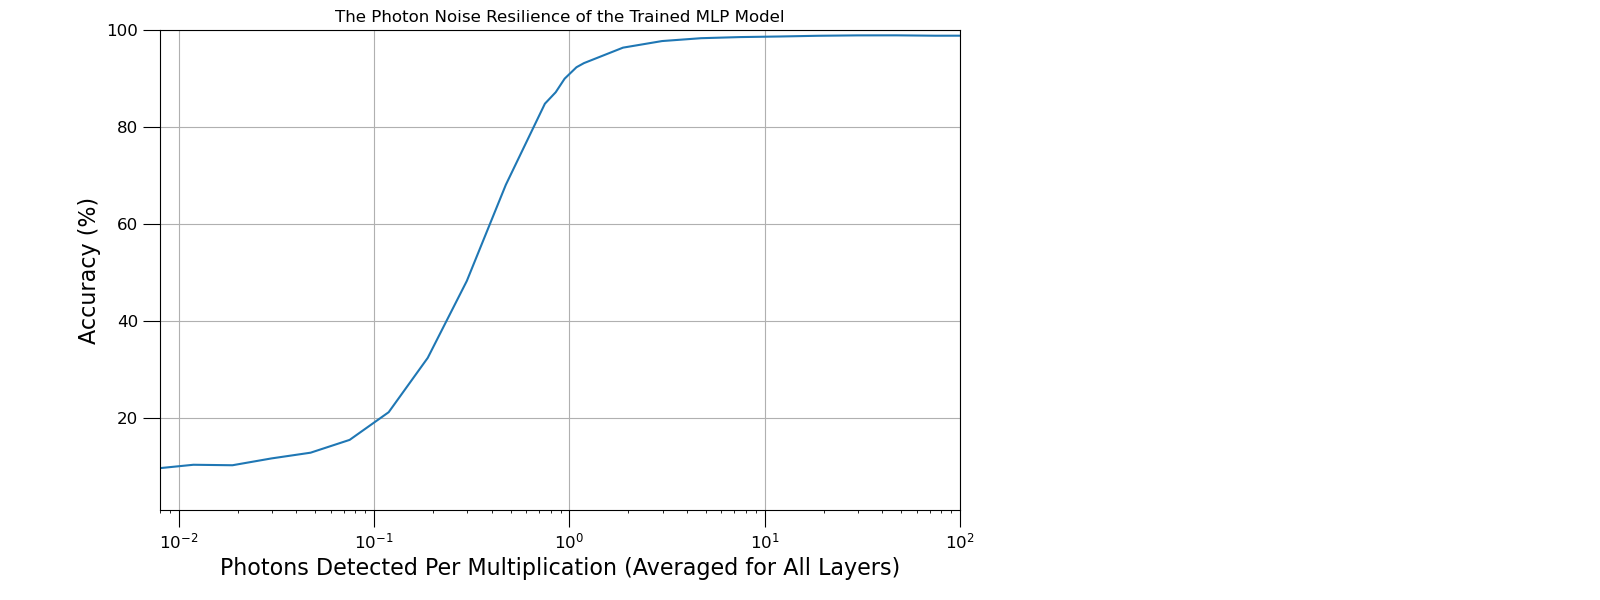

In [85]:
"""
Plot model accuracy with decreasing photon budget (photons per multiplication)
"""
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.set_position([0.1,0.15,0.5,0.8])
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim(1, 100)
ax.set_xlim(0.008,100)
ax.set_xlabel("Photons Detected Per Multiplication (Averaged for All Layers)")
ax.set_ylabel("Accuracy (%)")
ax.grid(True)
ax.tick_params(length=12)
line_dict = {0: "solid", 1: "dashed", 2:"dotted"}

df = df_state
avg_trans = [0.48, 0.42, 0.39] # The average transmission for the matrix for each fc layer.
x = df["max p/mul"] * (0.48*784*100 + 0.42*100*100 + 0.39*100*10)/(784*100 + 100*100 + 100*10)
y = df["accu_ref_fullres"]
ax.plot(x, y)

#ax.legend(bbox_to_anchor=(1.03, 1.0))
plt.title("The Photon Noise Resilience of the Trained MLP Model")
plt.show()